<a href="https://colab.research.google.com/github/stenoe/FEDS/blob/main/notebooks/LectureNotebooks/FEDS_lecture_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moving towards machine learning

## 1 Read data from github using python directly

Often, we have the data in a repository like Github or Kaggle. One way to download data is to go to the website, find the data, download to your computer and then, in case you use Google Colab you need to upload them again.

In this small section, I show how to download data directly from these sources into the Colab environment.

In [15]:
import requests
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")

# If the data folder doesn't exist, download it and prepare it...
if data_path.is_dir():
  print(f"{data_path} directory already exists... skipping creation")
else: 
  print(f"{data_path} does not exist, creating one...")
  data_path.mkdir(parents=True, exist_ok=True)

# Download temp data
with open(data_path / "land_global_temperature_anomaly-1850-2023.csv", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/stenoe/FEDS/main/data/land_global_temperature_anomaly-1850-2023.csv")
  print("Downloading data...")
  f.write(request.content)

data directory already exists... skipping creation


## 2. Load data for the temperature anomaly

We load the dataset used in a preivous lecture on the global temperature anomaly and use the data from te year 1975 onwards. This data is stored into a dataframe and then we run a simple linear regression using the **Ordinary least squares** method provided by numpy. The OLS method is minimising the distance between the fitted line and the data points!

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

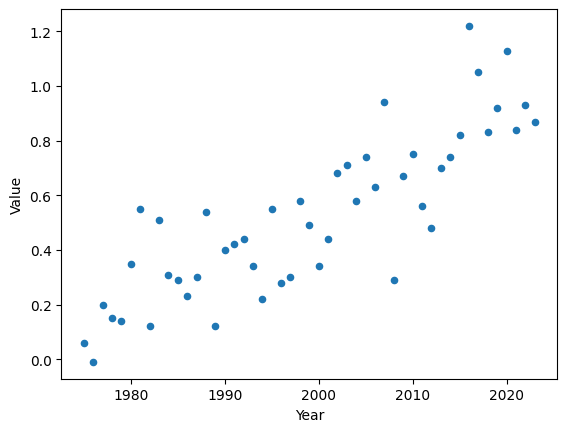

In [17]:
df = pd.read_csv("data/land_global_temperature_anomaly-1850-2023.csv", skiprows=4)
dfn = df[df.Year >= 1975]
dfn.plot.scatter("Year", "Value");

### 2.1 Prepare a simple linear regression to obtain a trend

We use here the simplest way with numpy where we do not get statistical parameters etc. 

To do so we:

1. use `np.polyfit()` to run the OLS to fit a linear equation. Remark, the linear equation is a polynome of degree 1. 
2. We calculate the trend by applying the estimated parameters $m$ and  $b$ of the linear function $f(x) = m x + b$ to the `np.polyval()` function. 
3. Then we plot the trendline.

In [18]:
reg = np.polyfit(dfn.Year, dfn.Value, deg=1)
reg

array([ 1.73520408e-02, -3.41614235e+01])

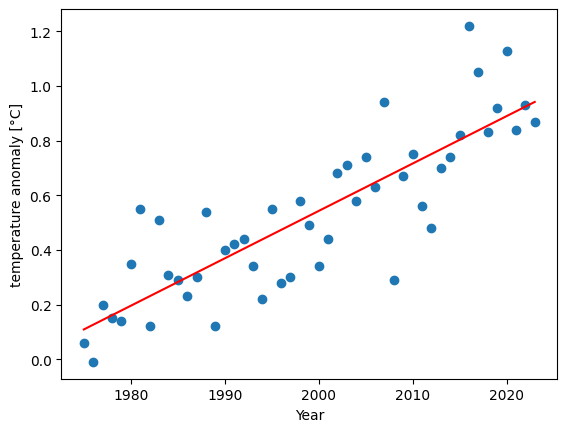

In [19]:
trend = np.polyval(reg, dfn.Year)
plt.scatter(dfn.Year, dfn.Value)
plt.plot(dfn.Year, trend, "r")
plt.xlabel('Year')
plt.ylabel('temperature anomaly [°C]')
plt.show()

## 3 Implementing a gradient descent algorithm to solve the linear regression task

**Remark:** The regression, linear or non-linear, is a way to predict continouusly values output! The algorithms to do that may differ. OLS is one algorithm and gradient descent another one.

**Gradient descent** can be used with many different functions, not only the linear one!

### 3.1 The first impression

from the figure above, we can assume that the temperature anomaly has in the ideal case a linear relatioship to the time in years and we can write that the relation as:

\begin{equation}
y = w x + b
\end{equation}

But, we do not know the parameter $w$ and $b$ of the relationship. We now want to "learn" these parameters from the given data. To do so, we have to look for values of the parameters $w$ and $b$ such that the mean squared error is minimised:

\begin{equation}
l \stackrel{\textrm{def}}{=} \frac{1}{N} \sum_{i=1}^N (y_i - (w x_i + b))^2
\end{equation}

This would be the OLS approach!

### 3.2 Gradient descent algorithm

The gradient descend starts with calculation of the partial derivative for all parameters:

\begin{eqnarray}
\frac{\partial l}{\partial w} &=& \frac{1}{N} \sum_{i=1}^N -2 x_i (y_i - (w x_i + b))\\
\frac{\partial l}{\partial b} &=& \frac{1}{N} \sum_{i=1}^N -2 (y_i - (w x_i + b))
\end{eqnarray}

Now, we need to know that the gradiend descent proceeds in **epochs**. In each epoch, it will use the dataset as a whole to update the parameters. As a first step, we need to set some initial values to the parameters $w$ and $b$, because we have no idea about them, we set them to zero so that we have $w \leftarrow 0$ and $b \leftarrow 0$. With that, we can start the algorihtm and at each epoch we update the parameters scaled by a **learning rate** $\alpha$. 

\begin{eqnarray}
w &\leftarrow& w - \alpha \frac{\partial l}{\partial w}\\
b &\leftarrow& b - \alpha \frac{\partial l}{\partial b}
\end{eqnarray}

We **subtract** the scaled partial derivative of the parameters because derivatives are indicators of change of a function. In our case, we want to **minimise** the objective function this moves the parameter depending on its sign. If the derivative is positive, then the function grows and we need to move to the opposite direction and we need to make the parameter smaller. If the derivative is negative we have to do the opposite and subtracting a negative value is increasing the parameter. 

This basic gradient descent algorithm is implemented in the function `update_w_and_b()` below.


In [20]:
def update_w_and_b(years, values, w, b, alpha):
    dl_dw = 0.0
    dl_db = 0.0
    N = len(years)
    
    for i in range(N):
        dl_dw += -2 * years[i] * (values[i] - (w * years[i] + b))
        dl_db += -2 * (values[i] - (w * years[i] + b))
        
    # update w and b
    w = w - (1/float(N)) * dl_dw * alpha
    b = b - (1/float(N)) * dl_db * alpha
    
    #print(w, b)

    return w, b

### 3.3 The training function

In the training function, we loop over the epochs. The number of epochs is a parameter that have to be chosen by us. To have a visual feedback if the algorithm is working we write an output of the progress every 400th step.

In [21]:
def train(years, values, w, b, alpha, epochs):
    for e in range(epochs):
        w, b = update_w_and_b(years, values, w, b, alpha)
        
        # log the calculation process
        if e % 400 == 0:
            print(f"epoch: {e} loss: {avg_loss(years, values, w, b)}, w: {w}, b: {b}")
            
    return w, b

### 3.4 The loss function

We use a loss function that is calculating the mean squared error. 

In [22]:
def avg_loss(years, values, w, b):
    N = len(years)
    total_error = 0.0
    for i in range(N):
        total_error += (values[i] - (w * years[i] + b))**2
        
    return total_error

### 3.5 Predicting unknown values from the data

We define a simple linear relation as predict function that takes the learned, hopefully optimal parameters and the unknown value $x$ and evaluates it.

In [23]:
def predict(x, w, b):
    return w * x + b

### 3.6 Running the algorithm

We run the algorithm for $\alpha = 0.001, w = 0.0, b = 0.0$, and 15 000 epochs. We can see in the output how the average loss is decreasing while looping through the epochs. 

At the end of the training period, we set a new, unkown value for the temperature anomaly $x = 0.35$ and predict the expected number of sold units. 

**Remark:** We scale the years to start from 0! In this way, the algorithm works properly. When using large x values possible rounding errors may lead to failure! In the best case you use data scaled between [0, 1] or [-1, 1], that guarantees that the algorithm is working.

In [24]:
w, b = train((dfn.Year-1975).tolist(), 
             dfn.Value.tolist(), 
             0.0, 0.0, 0.001, 15000)
x_new = 27.
y_new = predict(x_new, w, b)
print(y_new)

epoch: 0 loss: 6.3524963618285755, w: 0.03215551020408164, b: 0.0010506122448979591
epoch: 400 loss: 1.3017512725111478, w: 0.020075253869057785, b: 0.02083580365647573
epoch: 800 loss: 1.268705872683487, w: 0.019568189645940707, b: 0.03722544013194228
epoch: 1200 loss: 1.24682091976631, w: 0.0191555411447619, b: 0.0505633145433762
epoch: 1600 loss: 1.2323271879099889, w: 0.01881972809039501, b: 0.06141766717538721
epoch: 2000 loss: 1.222728434651623, w: 0.018546443667548273, b: 0.0702509315641301
epoch: 2400 loss: 1.2163714753102775, w: 0.01832404500019607, b: 0.07743943578973643
epoch: 2800 loss: 1.21216145646931, w: 0.01814305712417732, b: 0.08328943537396899
epoch: 3200 loss: 1.209373290352528, w: 0.017995769320451854, b: 0.08805016084083526
epoch: 3600 loss: 1.2075267736055908, w: 0.017875906611393808, b: 0.09192443581206011
epoch: 4000 loss: 1.2063038823021632, w: 0.017778362424710734, b: 0.09507731800556778
epoch: 4400 loss: 1.2054939989677835, w: 0.01769898103553277, b: 0.09764

### 3.7 Predicting multiple values

We can use the numpy packages `linspace()` function and create a range of input data. Then we use predict to get a range of output data. Finally these are plotted over the trainig data.

**Remark:** Remeber the scaling! we have to use it here as well and then transfer the grphical output to the right scale.

In [25]:
xn = np.linspace(0,2023-1975,100)
yn = predict(xn, w, b)

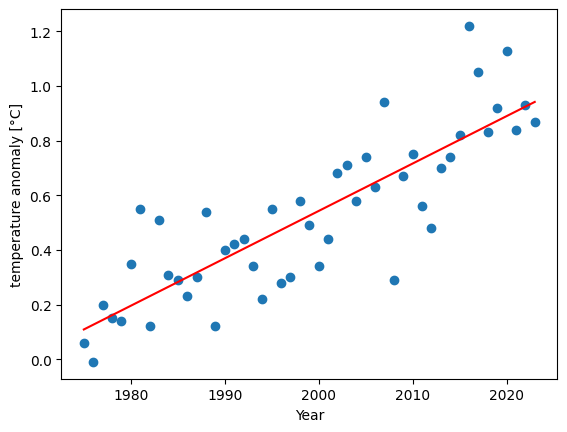

In [26]:
plt.figure();
plt.scatter(dfn.Year, dfn.Value)
plt.plot(xn+1975, yn, color='red')
plt.xlabel('Year')
plt.ylabel('temperature anomaly [°C]')
plt.show()

## 4 Use the scikit learn buildin ML algorithm

This example is using the stochastic gradient descent (SDG) regression algorithm. Here, we need to split the data into a trainig and testing dataset.


In [27]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset and reshape to fit the needs of the 
X, y = np.array(dfn.Year-1975).reshape(-1,1), np.array(dfn.Value)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # change the random_state to have different splits

# Create an instance of SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.001)

# Fit the model to the training data
sgd_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = sgd_reg.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

Mean squared error: 0.022061269877805358


### 4.1 The quality is not very good!

But that is normal for such a small dataset! SDGRegressor is tuned for very big datasets!

**Note:** We also have to use the scaling here because this would fail when using the shifted x-axis.

**Note:** The figure below shows that we have **only** prediction where the test data are located!

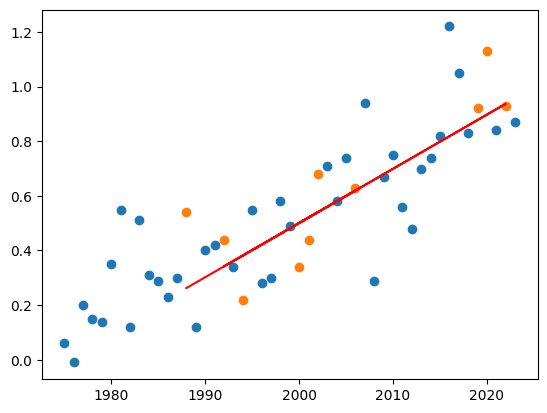

In [28]:
plt.scatter(X_train+1975, y_train)
plt.scatter(X_test+1975, y_test)
plt.plot(X_test+1975, y_pred, "r")
plt.show()